#  Dutch Restaurant reviews

What are the most negative and positive words in Dutch restaurant reviews?  Analysis using the review texts from reviews scraped already some time ago from the iens.nl website. 

In [1]:
######## set up things ####################

import datatable as dt
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
sns.set(rc={'figure.figsize':(10,6)})

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, accuracy_score
from sklearn.linear_model import LogisticRegression

from langdetect import detect
import re 
import spacy
nlp = spacy.load("nl_core_news_sm")

### Import data 
All reviews are in a zipped csv file, but this file was too big to share on github. 

So I splitted the file into two chunks with the command line tool split. These two parts, restaurantaa and restaurantab, need to be put together first.

In [2]:
!cat restauranta* > all_reviews.zip

In [3]:
### I am using the fread function in datatable to import zipped CSV text file, it is a bit faster than pandas.....
iens = dt.fread('all_reviews.zip')
iens.shape

(211140, 9)

In [4]:
### show some rows
iens.tail(5)

,reviewer,RestaurantNaam,Review,keuken,datum,eten,service,decor,ID
,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪
0,marian_groot,Het Ei Van Columbus,Heerlijk gegeten! Vooraf een heerlijke proeverij w…,FRANS,23/06/2013,8,9,8,211136
1,Kremers,Het Ei Van Columbus,Vanwege verjaardag van Oma uit eten. Keuzemenu bes…,FRANS,15/06/2013,8,8,7,211137
2,Mark-Gerards,Het Ei Van Columbus,Wij hebben hier met 6 personen gegeten en het is o…,FRANS,29/12/2012,10,10,1,211138
3,posth151,Het Ei Van Columbus,De bediening was zonder meer vriendelijk en gastvr…,FRANS,28/12/2012,7,8,6,211139
4,CulinairOegstgeest,Het Ei Van Columbus,Lekker gegeten in dit restaurant op mooie lokatie …,FRANS,09/11/2012,7,7,7,211140


In [5]:
### show one review in full length
iens[3,2]

"Wat moet je hier nu weer mee?Goede cijfers op de Iens app, maar al schrijvende komt er weer een proest van humoristische verbazing boven. Dit is een leuke poging tot restaurant, met niet goed opgeleid personeel dat wel heel erg haar best doet en een maaltijd die ternauwernood volstaat voor de prijs.Matias zit aan een drukke straat met heel veel restaurantjes, de proppers staan voor de deur. Dit was onze 2e keus, maar we moesten te lang wachten bij onze 1e keus voor spareribs en cocktails. Toen wij aankwamen, na een hele leuke dag Rijksmuseum, zaten er uitsluitend toeristen binnen. De groep Amerikaanse jongeren waren over de korting aan het bakkeleien, waarmee blijkbaar geadverteerd werd buiten.Dit restaurantje is niet groot, een tafel op 10. Het personeel telde 6 tot 8 mensen, zo telde ik snel. Er was niet veel te doen, dus hingen ze een beetje rond. Wel heel vriendelijk overigens.De maaltijden zijn Mexicaans, met was Oosterse invloeden. Margarita's zijn goed, verhoudingsgewijs duur. 

In [5]:
reviews = iens.to_pandas()

#### Language detection

We focus on Dutch reviews only. Use the `langdetect`package to detect the language of all reviews. This will take some time to process all 211K reviews. almost 25 min on my laptop

In [6]:
%%time
reviews["language"] = reviews.Review.apply(detect)

CPU times: user 24min 39s, sys: 8.36 s, total: 24min 47s
Wall time: 24min 51s


In [7]:
reviews.language.value_counts()

nl    210354
af       485
en       288
no         5
de         3
so         2
it         2
sl         1
Name: language, dtype: int64

In [8]:
### take only Dutch reviews with non missing 'eten' (food) score
reviews_NL = (
    reviews
    .query('language =="nl"')
    .dropna(subset=['eten', 'Review'])
)
reviews_NL.to_pickle("reviews_NL.pck")

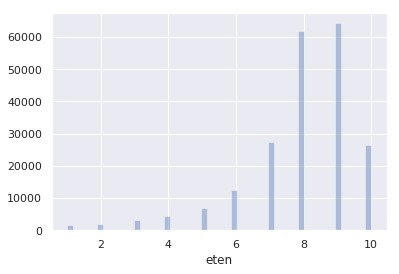

In [9]:
### Overview of the score given
sns.distplot(reviews_NL.eten, kde = False)

In [10]:
### example reviews with bad score
pd.options.display.max_colwidth = 1000
reviews_NL.query('eten < 4').sample(5)[["Review", "eten"]]

,Review,eten
144564,"Wat een drama, dat Maz Mez. Hebben er gegeten met een Groupon-deal. Maar goed dat er voor de deur een supermarkt zit die ’s avonds open is, want daar hebben we snel nog even wat te eten gehaald omdat we nog steeds honger hadden. We voelen ons echt zwaar afgezet met deze deal. Honderd euro waard? Ja, wel als je dan per persoon 10 tapas mag bestellen (zoals bij elk normaal tapasrestaurant), of in elk geval 10 tapas van voldoende grootte krijgt. Maar 1 inktvisringetje per persoon noem ik dus geen tapas. En een half geitenkaaskroketje p.p. ook niet. Of vier minuscule schijfjes stokbrood om de ‘aioli’ in te dopen (een substantie die trouwens weinig met echte aioli te maken had). Of patatas bravas met een soort tomatenpuree? Wij gaan voortaan toch maar weer naar een tapasrestaurant met minder pretenties waar je wel waar voor je geld krijgt.",2.0
110089,"Het eten was van slechte kwaliteit, salade zonder dressing, fish ribs and wings hield in: klein stukje spare rib wat erg droog was, 3 garnalen(die wel smaakten) en 2 kipvleugeltjes die flauw waren. Toetje pancake met bosvruchten dressing???? Geen bosvruchten dressing te zien, wel een rode streep over het bord, maar dat smaakte melig/zout/onbestendig. Dame Blanche leek van oud vanille ijs. Koffie was zo bitter dat heb ik nog nooit meegemaakt. De droge huiswijn smaakte naar bier, de zoete was wel te drinken. Ze hadden waarschijnlijk personeelstekort want na 1 uur hadden we nog niet eens een voorgerecht, laat staan stukje brood gehad. We gaan regelmatig uit eten, maar dit was wel het slechtste wat we meegemaakt hebben. Ook geen gezellig restaurant om binnen te zitten, grote ruimte met bar.",2.0
65115,"Zeer onvriendelijke eigenaar. Prijs kwaliteit buiten proporties, 9,50 voor 5 garnalen? Er mag meer niet dan wel. De klant Is niet welkom en al helemaal niet koning.",2.0
31339,Als vegetariër hier Niet eten een drie Luik ik vette noedels en loempia waarvan ze weigeren toe te geven dat het er niet uitzag (en smaak was nog slechter) de Quick was oké maar omdat de rest zo slecht was ook daar niet van genoten,1.0
140998,"Helaas geen goede ervaring. Eten is welliswaar betaalbaar, maar van zeer matige kwaliteit. Draadjesvlees leek uit een kant en klaar groothandel bakje, veel stukken vet, amper een half champignonnetje in de ''saus''. Partner had een smakeloze kipsate waar ook de nodige stukken vet nog aanzaten. Frites qua smaak ook beneden peil. Helaas een verslechtering tov de vorige eigenaar. Hier komen we niet meer terug.",3.0


## Preparing text for further analysis

In [2]:
reviews_nl = pd.read_pickle("reviews_NL.pck")

### count the number of words per review

In [3]:
%%time
### get the number of words per review
reviews_nl = (
    reviews_nl
    .assign(
        n_words = reviews_nl.Review.apply(lambda x : len(re.findall(r'\w+', x)))
    )
)

CPU times: user 10.7 s, sys: 62.5 ms, total: 10.8 s
Wall time: 10.7 s


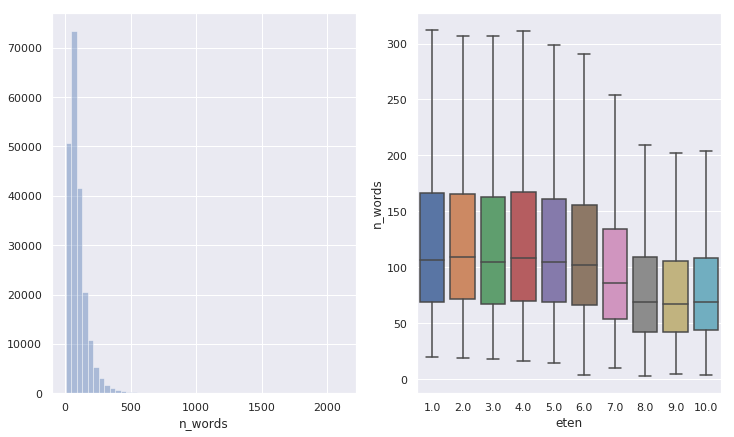

In [13]:
fig, axes = plt.subplots(1,2,  figsize=(12,7))

sns.distplot(reviews_nl.n_words, kde=False, ax=axes[0])
sns.boxplot(y = "n_words", x = "eten", data = reviews_nl, showfliers=False, ax=axes[1])

seems that people who give lower scores ( eten <7) tend to use more words to write the review

### remove stop words and punctuation

In [5]:
def clean_review(x):
    doc = nlp(x)
    tokens = [token.text for token in doc if (not token.is_punct) & (not token.is_stop)]
    return " ".join(tokens)

In [15]:
clean_review(reviews_nl.iloc[3,2])

"Wat weer mee?Goede cijfers Iens app schrijvende komt weer proest humoristische verbazing boven Dit leuke poging restaurant goed opgeleid personeel heel erg best doet maaltijd ternauwernood volstaat prijs Matias zit drukke straat heel restaurantjes proppers staan deur Dit onze 2e keus moesten lang wachten onze 1e keus spareribs cocktails Toen aankwamen hele leuke dag Rijksmuseum zaten uitsluitend toeristen binnen De groep Amerikaanse jongeren korting bakkeleien waarmee blijkbaar geadverteerd buiten Dit restaurantje groot tafel 10 Het personeel telde 6 8 mensen telde snel Er hingen beetje rond Wel heel vriendelijk overigens De maaltijden Mexicaans Oosterse invloeden Margarita 's goed verhoudingsgewijs duur Enchilada 's Fajitas pollo beide bord vol eten aardig smaakvol weinig inspiratie beter zeg hehe).We verwachtten sfeervolle Caribische muziek helaas De radio stond lekker handig nieuws hebt gemist Een grinnik moeilijk onderdrukken In geluidsinstallatie mogen investeren klonk muziek str

In [6]:
%%time
review_sample = reviews_nl.sample(20000)
review_sample = (
    review_sample
    .assign(
        cleaned_review = review_sample.Review.apply(clean_review)
    )
)  

CPU times: user 39min 17s, sys: 1min 4s, total: 40min 21s
Wall time: 10min 33s


In [7]:
review_sample.to_pickle

In [18]:
pd.options.display.max_colwidth = 1000
review_sample[["Review", "cleaned_review"]].sample(5)

,Review,cleaned_review
73571,Tijdje terug met 6 personen geluncht. Prime ligging en leuke ambiance. Genoeg keuze op de kaart en redelijke vlotte bediening (waarschijnlijk nieuwe)! Wij komen snel terug voor een lekkere lunch,Tijdje terug 6 personen geluncht Prime ligging leuke ambiance Genoeg keuze kaart redelijke vlotte bediening waarschijnlijk nieuwe Wij komen snel terug lekkere lunch
309,"""Wij gingen, na al eerder, in dit restaurant eten.We kregen vooraf van het huis stokbrood met boter en kruidenboter.Ook een karaf water werd niet in rekening gebracht.Heerlijke moezelwijn, Piesporter Michelsberg.Als voorgerecht namen we een mosterdsoep en een kreeftensoep met een scheutje cognac. Heel netjes dat ze vooraf vragen of je inderdaad een scheutje cognac in de soep wilt hebben.Allebei de soepen heerlijk van smaak. Vooral de kreeftensoep is een aanrader. Zo heerlijk van smaak en er zit veel kreeft in de soep. Top.Als hoofdgerecht namen we gamba's in knoflooksaus en de specialiteit van het huis de tournedos 'Stroganoff'.Normaal kun je deze specialiteit krijgen vanaf 2 personen. Maar omdat het restaurant niet helemaal vol zat kon het ook voor 1 persoon. Heel klantvriendelijk dus.Ook deze beide hoofdgerechten waren heerlijk. De tournedos ' Stroganoff\"" blijft een traktatie. Lekker mals vlees, zeer goede smaak en een overheerlijke saus erbij. Dit wordt bij je tafel klaargemaak...",Wij gingen eerder restaurant eten We kregen vooraf huis stokbrood boter kruidenboter Ook karaf water rekening gebracht Heerlijke moezelwijn Piesporter Michelsberg Als voorgerecht namen mosterdsoep kreeftensoep scheutje cognac Heel netjes vooraf vragen inderdaad scheutje cognac soep wilt Allebei soepen heerlijk smaak Vooral kreeftensoep aanrader Zo heerlijk smaak zit kreeft soep Top Als hoofdgerecht namen gamba 's knoflooksaus specialiteit huis tournedos Stroganoff'.Normaal kun specialiteit krijgen vanaf 2 personen Maar restaurant helemaal vol zat 1 persoon Heel klantvriendelijk Ook beide hoofdgerechten heerlijk De tournedos Stroganoff\ blijft traktatie Lekker mals vlees zeer goede smaak overheerlijke saus erbij Dit wordt tafel klaargemaakt Een aanrader Verder wordt eten groente salade gebakken aardappels frieten geserveerd Prima allemaal Dessert genomen genoeg hadden gehad Resumerend goede aardige bediening Heerlijk smaakvolle gerechten We komen zeker terug
203705,Ik ben gisteren avond uiteten gegaan in het grand cafe cinetone de bediening vond ik top ze waren vriendelijk en snel ik hoeften niet lang te wachten op het eten de ravioli pasta was heerlijk de kok had zijn best gedaan en de tijd genomen maar ik hoefden tog niet lang te wachten de decoratie zag er gezzelig uit.,Ik gisteren avond uiteten gegaan grand cafe cinetone bediening vond top vriendelijk snel hoeften lang wachten eten ravioli pasta heerlijk kok best gedaan tijd genomen hoefden tog lang wachten decoratie zag gezzelig
68726,"Een aardig restaurant aan het eind van de Lijnbaan. We zijn hier vooral gaan eten omdat het zo dicht bij het hotel zat. Het personeel is inderdaad zeer vriendelijk. Het restaurant heeft ook wel een hoog knuffelgehalte met al die vaste gasten. Dat zegt wel iets over het restaurant in positieve zin. Het eten vonden wij daarentegen net aan 'goed'. Mijn vrouw en ik hadden beiden een soort mix grill met drie soorten beef. Best aardig bereid, maar de entrecote was heel erg 'rare', zeker niet medium. De borden zijn erg saai opgemaakt, salades waren ook wel een beetje makkelijk met grote stukken iceberg sla, mais en rode bonen. We hadden net een aperatiefje bestelt met wat stokbrood en kruidenboter, toen het hoofdgerecht ook al kwam. Mensen achter ons kregen 3 minuten na bestelling hun voorgerechten. Dat gaat echt veel te snel.Al met al klopte het wel, was de kwaliteit van het eten niet slecht, maar ook niet goed. Het decor vonden wij wat 'verlopen'.",Een aardig restaurant eind Lijnbaan We vooral gaan eten dicht hotel zat Het personeel inderdaad zeer vriendelijk Het restaurant ho

### Count vectorizer for regularized logistic regression

In [8]:
### create binary target, bad reviews if score is < 6
review_sample = review_sample.assign(target = np.where(review_sample.eten < 6,1,0))

In [9]:
review_sample.target.value_counts()

0    18368
1     1632
Name: target, dtype: int64

In [10]:
cv = CountVectorizer(ngram_range=(1,2))
cv.fit(review_sample.cleaned_review)
X = cv.transform(review_sample.cleaned_review)
target = review_sample.target

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

In [11]:
X_train.shape

(15000, 618873)

### Logistic regression

In [12]:
for c in [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 1]:
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print (
        "Accuracy for C=%s: %s" 
        % (c, accuracy_score(y_val, lr.predict(X_val)))
    )

/home/longhowlam/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.9314
Accuracy for C=0.05: 0.941
Accuracy for C=0.25: 0.942
Accuracy for C=0.5: 0.9426
Accuracy for C=0.75: 0.9422
Accuracy for C=0.95: 0.942
Accuracy for C=1: 0.942


In [13]:
final_model = LogisticRegression(C=0.5)
final_model.fit(X_train, y_train)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

#### Look at top words that are distinguishes bad reviews and good reviews
Extract coefficient estimate from the logistic regression and see the biggest and smallest coefficients

In [17]:
#### The best and worst words......
wordcoef = pd.DataFrame({
    "word": cv.get_feature_names(),
    "coef":  final_model.coef_[0]
})

print("Number of coefficients", wordcoef.shape)
print("Number of nonzero coefficients", wordcoef.query('(coef < 0) | (coef > 0)'). shape)

wordcoef.sort_values(by="coef", inplace = True)

Number of coefficients (618873, 2)
Number of nonzero coefficients (493872, 2)


In [18]:
wordcoef.head(10)

,word,coef
230807,heerlijk,-1.576029
232264,heerlijke,-1.070366
416812,prima,-0.938491
517821,uitstekend,-0.905680
314661,lekkere,-0.843254
190838,genoten,-0.760830
506610,top,-0.724982
211754,goed,-0.699639
483126,super,-0.679349
560607,voortreffelijk,-0.669676


In [19]:
wordcoef.tail(10)

,word,coef
158213,flauw,0.850897
424001,rauw,0.856446
311502,leek,0.893254
458162,slechte,0.910643
457742,slecht,0.921125
122919,droog,0.931011
295528,koud,0.984639
492562,teleurstelling,1.050974
368063,nooit,1.168271
462850,smakeloos,1.215781


## Word clouds

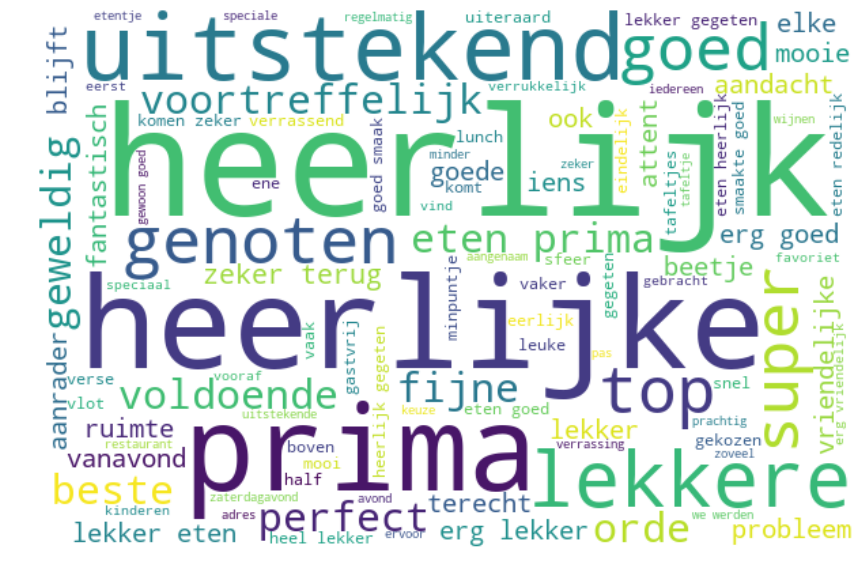

In [46]:
tmp = wordcoef.head(100)
tmp = tmp.assign(freq = -1*tmp.coef)
zz = tmp.set_index('word')["freq"].T.to_dict()

# Create and generate a word cloud image:
tmp = {"A":9, "B":0.10}
wordcloud = WordCloud( background_color="white", height=400, width=600).generate_from_frequencies(zz)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

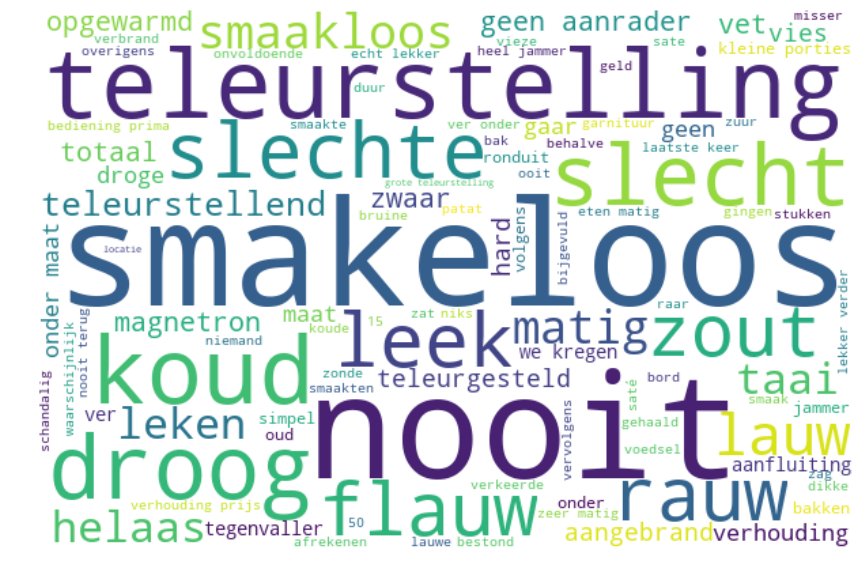

In [47]:
tmp = wordcoef.tail(100)
tmp = tmp.assign(freq = tmp.coef)
zz = tmp.set_index('word')["freq"].T.to_dict()

# Create and generate a word cloud image:
tmp = {"A":9, "B":0.10}
wordcloud = WordCloud( background_color="white", height=400, width=600).generate_from_frequencies(zz)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
